# Evalution of Replicate Agreement
In this notebook, I want to explore how well the replicates of the dual RNA-seq experiements agree with one another.
For that purpose, I'll load three different runs of the GCN for the three different replicates.
Then, I'll see how much they have in common.

In [1]:
import numpy as np
import pandas as pd
import h5py

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn

from statsmodels.stats.inter_rater import fleiss_kappa, cohens_kappa
%matplotlib inline

## Loading GCN Predictions

In [2]:
model_dir_rep1 = '../data/GCN/training/replicate1/'
model_dir_rep2 = '../data/GCN/training/replicate2/'
model_dir_rep3 = '../data/GCN/training/replicate3/'
data_file = '../data/preprocessing/legionella_gcn_input.h5'
CLASSIFICATION_THRESHOLD = 0.5

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

# get a label dataframe
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'name']).drop('ID', axis=1)
labels_df['label'] = (y_train[:,0] | y_test[:,0])
labels_df['train_label'] = y_train[:, 0]
labels_df['test_label'] = y_test[:, 0]

def load_predictions(model_dir):
    # load predictions
    predictions = pd.DataFrame.from_csv(model_dir + '/predictions.tsv', sep='\t', header=0)
    pos_predicted = predictions[predictions.Prob_pos > CLASSIFICATION_THRESHOLD]

    print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
    pos_predicted.sort_values(by='Prob_pos', ascending=False).to_csv(model_dir + '/positive_prediction.txt', sep='\t')
    return predictions, pos_predicted

def prediction_stats(predictions, labels_df):
    labels_with_pred = labels_df.join(predictions)
    predictions_for_knowns = labels_with_pred[labels_with_pred.label == 1]
    pos_pred = predictions_for_knowns[predictions_for_knowns.Prob_pos > CLASSIFICATION_THRESHOLD]
    known_pos_predictions = pos_pred.shape[0]
    number_of_knowns = predictions_for_knowns.shape[0]
    pred_test = pos_pred[pos_pred.test_label == 1]
    pred_train = pos_pred[pos_pred.train_label == 1]

    print ("Predicted {} out of {} known infection genes".format(known_pos_predictions,
                                                                 number_of_knowns)
          )
    print ("Out of these {}, {} were not shown during training.".format(number_of_knowns,
                                                                        y_test[:, 0].sum())
          )
    print ("Predicted {} out of {} test genes ({}%)".format(pred_test.shape[0],
                                                            y_test[:,0].sum(),
                                                            pred_test.shape[0]/y_test[:,0].sum()*100.)
          )
    print ("Predicted {} out of {} train genes ({}%)".format(pred_train.shape[0],
                                                             y_train[:,0].sum(),
                                                             pred_train.shape[0]/y_train[:,0].sum()*100.)
          )
    predictions_for_knowns.sort_values(by='Prob_pos', ascending=False)
    return predictions_for_knowns

## Basic Statistics over Replicates

In [3]:
pred_rep1, pospred_rep1 = load_predictions(model_dir_rep1)
pred_rep2, pospred_rep2 = load_predictions(model_dir_rep2)
pred_rep3, pospred_rep3 = load_predictions(model_dir_rep3)

Predicted 1487 genes of 10823 total to be involved in infection
Predicted 1984 genes of 10823 total to be involved in infection
Predicted 792 genes of 10823 total to be involved in infection


In [4]:
pred_knowns_rep1 = prediction_stats(pred_rep1, labels_df)
print()
pred_knowns_rep2 = prediction_stats(pred_rep2, labels_df)
print()
pred_knowns_rep3 = prediction_stats(pred_rep3, labels_df)

Predicted 30 out of 38 known infection genes
Out of these 38, 16 were not shown during training.
Predicted 11 out of 16 test genes (68.75%)
Predicted 19 out of 22 train genes (86.36363636363636%)

Predicted 29 out of 38 known infection genes
Out of these 38, 16 were not shown during training.
Predicted 12 out of 16 test genes (75.0%)
Predicted 17 out of 22 train genes (77.27272727272727%)

Predicted 20 out of 38 known infection genes
Out of these 38, 16 were not shown during training.
Predicted 7 out of 16 test genes (43.75%)
Predicted 13 out of 22 train genes (59.09090909090909%)


## Similarity of Predictions
A lot of research has been done already to measure the extend to which different raters agree on an observation.
This is called **inter-rater reliability** and can be used here to determine how well the predictions for the three replicates differ.

### Fleiss' Kappa Statistics
That  is a measure usable for categorical predictions and any number of raters. It's thus perfect for me.

In [5]:
all_pos = pd.concat([pred_rep1.Prob_pos > CLASSIFICATION_THRESHOLD,
                     pred_rep2.Prob_pos > CLASSIFICATION_THRESHOLD,
                     pred_rep3.Prob_pos > CLASSIFICATION_THRESHOLD], axis=1)
all_pos.columns = ['predicted_rep1', 'predicted_rep2', 'predicted_rep3']
all_neg = pd.concat([pred_rep1.Prob_pos <= CLASSIFICATION_THRESHOLD,
                     pred_rep2.Prob_pos <= CLASSIFICATION_THRESHOLD,
                     pred_rep3.Prob_pos <= CLASSIFICATION_THRESHOLD], axis=1)
all_neg.columns = ['not_predicted_rep1', 'not_predicted_rep2', 'not_predicted_rep3']
count_table = pd.concat([all_pos.sum(axis=1), all_neg.sum(axis=1)], axis=1)
count_table.columns = ['Num_Pos', 'Num_Neg']
print ("Fleiss' Kappa Value: {}".format(fleiss_kappa(count_table)))

Fleiss' Kappa Value: 0.43914760925238777


### Agreement Statistics
Just print some basic statistics as to how many genes are predicted by all replicates and how many replicates make the same prediction. Also state the number of deviating genes and which of the replicates is most responsible for that.

In [6]:
num_all_pos = count_table[count_table.Num_Pos == 3].shape[0]
print ("Number of genes predicted by all replicates: {}".format(num_all_pos))
num_one_pos = count_table[count_table.Num_Pos >= 1].shape[0]
print ("Number of genes predicted in at least one replicate: {}".format(num_one_pos))
agreeing = all_pos[all_pos.apply(lambda x: min(x) == max(x), 1)]
print ("All Replicates agreeing on {} genes".format(agreeing.shape[0]))

correlations = all_pos.corr()
correlations

Number of genes predicted by all replicates: 560
Number of genes predicted in at least one replicate: 2637
All Replicates agreeing on 8746 genes


,predicted_rep1,predicted_rep2,predicted_rep3
predicted_rep1,1.000,0.447,0.559
predicted_rep2,0.447,1.000,0.434
predicted_rep3,0.559,0.434,1.000


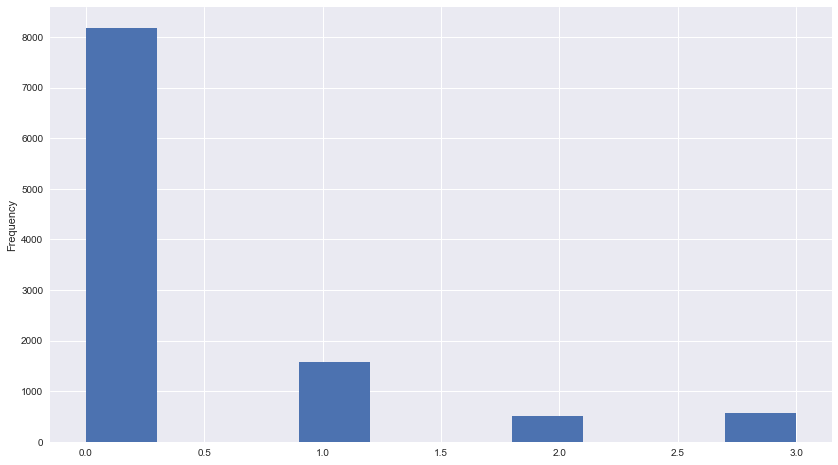

In [10]:
fig = plt.figure(figsize=(14, 8))
#plt.hist(count_table.Num_Pos, bins=np.arange(0, 4, 1))
count_table.Num_Pos.plot(kind='hist')